In [48]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from tqdm import tqdm
import os
import re
import sys
import time
import logging
import tempfile
from collections import Counter
from typing import List, Tuple
from tqdm import tqdm

import numpy as np
import pandas as pd

import rdkit
from rdkit import Chem
from rdkit.Chem import MolFromSmiles, MolToSmiles, CanonSmiles

import deepchem as dc
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_validate
from scipy.sparse import csr_matrix, lil_matrix

import atomInSmiles as ais
import json

In [49]:
#create teh vocabulary for all the words in the SMILES

class CreateVocab():
    def __init__(self, datasets):
        """
        Initialize the CreateVocab object with multiple datasets.

        :param datasets: List of datasets (strings) to build the vocabulary from.
        """
        self.stoi = {}
        self.itos = {}
        self.pad_token = '*'
        self.build_vocab(datasets)
        self.vocab_size = len(self.stoi)

    def build_vocab(self, datasets):
        """
        Build the vocabulary from the datasets.

        :param datasets: List of datasets (strings) to build the vocabulary from.
        """
        all_words = set()
        n = 1
        for dataset in datasets:
            dataset = self.preprocess_smile(dataset)
            name_d = str(n) + 'process_data'
            with open(name_d, 'w') as f:
                f.write(dataset)
            n += 1
            all_words.update(dataset.split())
        all_words = sorted(all_words)
        self.stoi = {word: i for i, word in enumerate(all_words)}
        self.itos = {i: word for word, i in self.stoi.items()}

    def preprocess_smile(self, dataset):

        #data = []
        data = ""
        for smile in dataset:
            sections = self.separate(smile)
            all_sections = self.show_sections(smile, sections)
            d = " ".join(all_sections)
            d = d.replace('\\n', '').replace('(', ' (').replace(')', ') ').replace('[', ' [').replace(']', '] ').replace('  ', ' ')
            d = d + '* '
            d = d.replace('  ', ' ')
            data += d
        #print(data)
        return data

    
    def separate(self, s):
        stack = []
        sections = []
        for i, c in enumerate(s):
            if c in ['(', '[']:
                stack.append((c, i))
            elif c in [')', ']']:
                while stack:
                    opening, start = stack[-1]  # Peek at the top of the stack
                    if (opening == '(' and c == ')') or (opening == '[' and c == ']'):
                        stack.pop()  # Remove the matching opening bracket
                        sections.append((start, i))
                        break
                    else:
                        stack.pop()  # Remove the non-matching opening bracket

        # Filter out overlapping sections
        non_overlapping_sections = []
        last_end = -1
        for start, end in sorted(sections, key=lambda x: x[0]):
            if start > last_end:
                non_overlapping_sections.append((start, end))
                last_end = end

        return non_overlapping_sections


    def show_sections(self, s, sections):
        all_sections = []
        last_end = 0  # To keep track of the last section's end index

        for start, end in sections:
            if start > last_end:
                # Add the section between the last end and this start
                all_sections.append(s[last_end:start])
            # Add the section within the current parenthesis/bracket
            all_sections.append(s[start:end+1])
            last_end = end + 1  # Update the last end index

        # Handle any remaining section after the last parenthesis/bracket
        if last_end < len(s):
            all_sections.append(s[last_end:])

        return all_sections
    
    def encode(self, text):
        """
        Encode the input SMILES string into a tensor of integers.

        :param smile: Input SMILES string.
        :return: Tensor of integers.
        """
        return [self.stoi[word] for word in text.split()]
    
    def decode(self, tensor):
        """
        Decode the input tensor of integers into a SMILES string.

        :param tensor: Input tensor of integers.
        :return: SMILES string.
        """
        return ''.join([self.itos[i] for i in tensor])
    

    

smile_1 = pd.read_csv('smile_1.csv')['smiles']
smile_2 = pd.read_csv('smile_2.csv')['smiles']
smile_3 = pd.read_csv('smile_3.csv')['canonical_smiles']


# Combine processed datasets
#datasets = [smile_1, smile_2, smile_3]
datasets = [smile_3]


# Create vocabulary
vocab = CreateVocab(datasets)

In [50]:
#open 3process_data and read the data
with open('3process_data', 'r') as f:
    text = f.read()


In [3]:
vocab = open('vocab_words.json', 'w')
json.dump(vocab.stoi, vocab)

AttributeError: '_io.TextIOWrapper' object has no attribute 'stoi'

In [24]:
#save the vocabulary
with open('vocab_words.json', 'w') as f:
    json.dump(vocab.stoi, f)

AttributeError: '_io.TextIOWrapper' object has no attribute 'stoi'

In [28]:
print(vocab.stoi)

{'#': 0, '#C': 1, '#CC)': 2, '#N': 3, '#N)': 4, '%11': 5, '%118)': 6, '%11=C': 7, '%11C': 8, '%12%13)': 9, '%14': 10, '(': 11, '(#CC1=CCCCC1)': 12, '(#CCN1CCCC1)': 13, '(#CCN1CCCCCC1)': 14, '(#Cc1ccccc1)': 15, '(#Cc1cncnc1)': 16, '(-': 17, '(-c1cc': 18, '(-c1cc3c': 19, '(-c1ccc': 20, '(-c1cccc': 21, '(-c1ccccc1)': 22, '(-c1ccccc1Cl)': 23, '(-c1ccccc1F)': 24, '(-c1ccccn1)': 25, '(-c1cccnc1)': 26, '(-c1cccs1)': 27, '(-c1csc': 28, '(-c1nc': 29, '(-c2': 30, '(-c2c': 31, '(-c2c3c': 32, '(-c2c3c4n': 33, '(-c2c3ccc': 34, '(-c2c3ccccc3': 35, '(-c2c3ccccc3c': 36, '(-c2c3ccccc3c3n2CCS3)': 37, '(-c2c3ccccc3c3sc4ccccc4n23)': 38, '(-c2c3ccccc3nc3ccccc23)': 39, '(-c2c3oc4c': 40, '(-c2c3oc4cc': 41, '(-c2c3sc': 42, '(-c2cc': 43, '(-c2cc3': 44, '(-c2cc3c': 45, '(-c2cc3c4c': 46, '(-c2cc3c4ccccc4nc': 47, '(-c2cc3c4ccccc4oc4nc': 48, '(-c2cc3c4nn': 49, '(-c2cc3c4nnc': 50, '(-c2cc3cc': 51, '(-c2cc3ccc': 52, '(-c2cc3ccc4c': 53, '(-c2cc3ccc4cccnc4c3o2)': 54, '(-c2cc3cccc': 55, '(-c2cc3ccccc3': 56, '(-c2cc3ccc

In [5]:
text = open("C:\\Users\\Rebe\\Documents\\Python programms\\Capstone_code\\NLP_approach\\3process_data", "r")
text = text.read()
print(text)

CC (C) CN (Sc1ccc2c (c1) CCO2) [C@H] (CO) CCCCNC (=O) [C@@H] (Cc1cccc2ccccc12) NC (=O) N1CCOCC1* CC (C) CN (Sc1ccc2c (c1) OCCO2) [C@H] (CO) CCCCNC (=O) [C@@H] (Cc1cccc2ccccc12) NC (=O) N1CCOCC1* CC (C) CN ( [C@H] (CO) CCCCNC (=O) [C@H] (Cc1ccccc1Br) NC (=O) N1CCOCC1) S (=O) (=O) c1ccc2c (c1) CCO2* Cc1c (O) cccc1C (=O) N [C@@H] (Cc1ccccc1Br) C (=O) NCCCC [C@@H] (CO) N (CC (C) C) S (=O) (=O) c1ccc (N) cc1* CC (C) CN ( [C@H] (CO) CCCCNC (=O) [C@H] (Cc1ccccc1Br) NC (=O) c1cccc (=O) [nH] 1) S (=O) (=O) c1ccc (N) cc1* Cc1ccccc1C [C@H] (NC (=O) c1cccnc1) C (=O) NCCCC [C@@H] (CO) N (CC (C) C) S (=O) (=O) c1ccc (N) cc1* O=C (O) CNC (=O) c1c (=O) oc (O) c2cc (Br) ccc12* C [C@H] (NC (=O) c1c (=O) oc (O) c2cccc (-c3cccc (C (F) (F) F) c3) c12) C (=O) O* Cc1ccccc1C [C@H] (NC (=O) c1cccc (C) c1O) C (=O) NCCCC [C@@H] (CO) N (CC (C) C) S (=O) (=O) c1ccc (N) cc1* COC (=O) N [C@@H] (CC1CCCCC1) C (=O) NCCCC [C@@H] (CO) N (CC (C) C) S (=O) (=O) c1ccc (N) cc1* CC (C) CN ( [C@H] (CO) CCCCNC (=O) [C@H] (CC1CC

In [5]:
print(text)

CC (C) CN (Sc1ccc2c (c1) CCO2) [C@H] (CO) CCCCNC (=O) [C@@H] (Cc1cccc2ccccc12) NC (=O) N1CCOCC1* CC (C) CN (Sc1ccc2c (c1) OCCO2) [C@H] (CO) CCCCNC (=O) [C@@H] (Cc1cccc2ccccc12) NC (=O) N1CCOCC1* CC (C) CN ( [C@H] (CO) CCCCNC (=O) [C@H] (Cc1ccccc1Br) NC (=O) N1CCOCC1) S (=O) (=O) c1ccc2c (c1) CCO2* Cc1c (O) cccc1C (=O) N [C@@H] (Cc1ccccc1Br) C (=O) NCCCC [C@@H] (CO) N (CC (C) C) S (=O) (=O) c1ccc (N) cc1* CC (C) CN ( [C@H] (CO) CCCCNC (=O) [C@H] (Cc1ccccc1Br) NC (=O) c1cccc (=O) [nH] 1) S (=O) (=O) c1ccc (N) cc1* Cc1ccccc1C [C@H] (NC (=O) c1cccnc1) C (=O) NCCCC [C@@H] (CO) N (CC (C) C) S (=O) (=O) c1ccc (N) cc1* O=C (O) CNC (=O) c1c (=O) oc (O) c2cc (Br) ccc12* C [C@H] (NC (=O) c1c (=O) oc (O) c2cccc (-c3cccc (C (F) (F) F) c3) c12) C (=O) O* Cc1ccccc1C [C@H] (NC (=O) c1cccc (C) c1O) C (=O) NCCCC [C@@H] (CO) N (CC (C) C) S (=O) (=O) c1ccc (N) cc1* COC (=O) N [C@@H] (CC1CCCCC1) C (=O) NCCCC [C@@H] (CO) N (CC (C) C) S (=O) (=O) c1ccc (N) cc1* CC (C) CN ( [C@H] (CO) CCCCNC (=O) [C@H] (CC1CC

In [51]:
encoded_text = vocab.encode(text)

# Train and test splits
data = torch.tensor(encoded_text, dtype=torch.long)

# Split the data into training and validation sets randomly
train_size = int(0.9 * len(data))
val_size = len(data) - train_size
train_data, val_data = torch.utils.data.random_split(data, [train_size, val_size])




In [58]:
# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 1200
eval_interval = 10
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 100
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.2 #Change of dropout form 0 to 0.2
# ------------

torch.manual_seed(1337)
vocab_size = len(vocab.stoi)

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [59]:
model = BigramLanguageModel()

In [9]:
model_state_path = "Only3_BPS.pkl"
model.load_state_dict(torch.load(model_state_path))

<All keys matched successfully>

In [60]:

m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

0.218501 M parameters


In [61]:

train_losses = []
val_losses = []


for iter in range(max_iters):
    # Evaluate the loss periodically
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        train_losses.append(losses['train'])
        val_losses.append(losses['val'])
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # Get a batch of data
    xb, yb = get_batch('train')

    # Forward pass and loss computation
    logits, loss = model(xb, yb)

    # Backpropagation
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)

step 0: train loss 5.0295, val loss 5.0621
step 10: train loss 4.0318, val loss 4.1856
step 20: train loss 3.7997, val loss 3.9437
step 30: train loss 3.7395, val loss 3.8846
step 40: train loss 3.6995, val loss 3.8730
step 50: train loss 3.6574, val loss 3.9207
step 60: train loss 3.6038, val loss 3.9544
step 70: train loss 3.5284, val loss 4.0457
step 80: train loss 3.4473, val loss 4.0226
step 90: train loss 3.3600, val loss 4.0847
step 100: train loss 3.2580, val loss 4.1353
step 110: train loss 3.1636, val loss 4.1452
step 120: train loss 3.0726, val loss 4.1738
step 130: train loss 2.9684, val loss 4.2209
step 140: train loss 2.8948, val loss 4.3249
step 150: train loss 2.8253, val loss 4.4130
step 160: train loss 2.7412, val loss 4.3536
step 170: train loss 2.6612, val loss 4.4740
step 180: train loss 2.5891, val loss 4.5147
step 190: train loss 2.5263, val loss 4.5896
step 200: train loss 2.4466, val loss 4.6496
step 210: train loss 2.3537, val loss 4.6711
step 220: train loss 

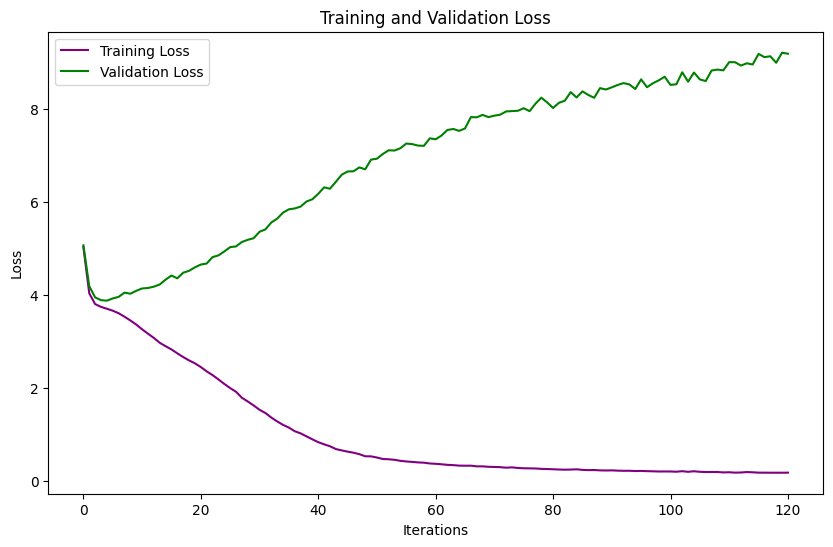

In [63]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='purple')
plt.plot(val_losses, label='Validation Loss', color='green')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [16]:
def separate(s):
    stack = []
    sections = []
    for i, c in enumerate(s):
        if c in ['(', '[']:
            stack.append((c, i))
        elif c in [')', ']']:
            while stack:
                opening, start = stack[-1]  # Peek at the top of the stack
                if (opening == '(' and c == ')') or (opening == '[' and c == ']'):
                    stack.pop()  # Remove the matching opening bracket
                    sections.append((start, i))
                    break
                else:
                    stack.pop()  # Remove the non-matching opening bracket

    # Filter out overlapping sections
    non_overlapping_sections = []
    last_end = -1
    for start, end in sorted(sections, key=lambda x: x[0]):
        if start > last_end:
            non_overlapping_sections.append((start, end))
            last_end = end

    return non_overlapping_sections


def show_sections(s, sections):
    all_sections = []
    last_end = 0  # To keep track of the last section's end index

    for start, end in sections:
        if start > last_end:
            # Add the section between the last end and this start
            all_sections.append(s[last_end:start])
        # Add the section within the current parenthesis/bracket
        all_sections.append(s[start:end+1])
        last_end = end + 1  # Update the last end index

    # Handle any remaining section after the last parenthesis/bracket
    if last_end < len(s):
        all_sections.append(s[last_end:])

    return all_sections

smiles = smiles 
s = smiles[0]
sections = separate(s)
all_sections = show_sections(s, sections)
" ".join(all_sections)

'CC (C) (C) c1ccc2occ (CC(=O)Nc3ccccc3F) c2c1\n'

In [17]:
def separate(s):
    stack = []
    sections = []
    for i, c in enumerate(s):
        if c in ['(', '[']:
            stack.append((c, i))
        elif c in [')', ']']:
            while stack:
                opening, start = stack[-1]  # Peek at the top of the stack
                if (opening == '(' and c == ')') or (opening == '[' and c == ']'):
                    stack.pop()  # Remove the matching opening bracket
                    sections.append((start, i))
                    break
                else:
                    stack.pop()  # Remove the non-matching opening bracket
    # Filter out overlapping sections
    non_overlapping_sections = []
    last_end = -1
    for start, end in sorted(sections, key=lambda x: x[0]):
        if start > last_end:
            non_overlapping_sections.append((start, end))
            last_end = end

    return non_overlapping_sections 



def show_sections(s, sections):
    all_sections = []
    last_end = 0  # To keep track of the last section's end index

    for start, end in sections:
        if start > last_end:
            # Add the section between the last end and this start
            all_sections.append(s[last_end:start])
        # Add the section within the current parenthesis/bracket
        all_sections.append(s[start:end+1])
        last_end = end + 1  # Update the last end index

    # Handle any remaining section after the last parenthesis/bracket
    if last_end < len(s):
        all_sections.append(s[last_end:])

    return all_sections


In [11]:
smiles_1 = pd.read_csv('smile_1.csv')
smiles = smiles_1['smiles']

In [109]:
text = ""

for i in tqdm(range(len(smiles))):
    sections = separate(smiles[i])
    all_sections = show_sections(smiles[i], sections)
    text += " ".join(all_sections)
    text.replace("\n", "")
    text = text.replace('(', ' (').replace(')', ') ').replace('[', ' [').replace(']', '] ').replace('  ', ' ')
    text += "* "

  0%|          | 0/249455 [00:00<?, ?it/s]

 40%|███▉      | 99154/249455 [2:18:11<31:26:17,  1.33it/s]  

In [14]:
#save text 

with open('smiles_1_processed.txt', 'w') as f:
    f.write(text)

In [13]:
#text = text.replace("\n", "")

print(text)

CC (C) CN (Sc1ccc2c (c1) CCO2) [C@H] (CO) CCCCNC (=O) [C@@H] (Cc1cccc2ccccc12) NC (=O) N1CCOCC1* CC (C) CN (Sc1ccc2c (c1) OCCO2) [C@H] (CO) CCCCNC (=O) [C@@H] (Cc1cccc2ccccc12) NC (=O) N1CCOCC1* CC (C) CN ( [C@H] (CO) CCCCNC (=O) [C@H] (Cc1ccccc1Br) NC (=O) N1CCOCC1) S (=O) (=O) c1ccc2c (c1) CCO2* Cc1c (O) cccc1C (=O) N [C@@H] (Cc1ccccc1Br) C (=O) NCCCC [C@@H] (CO) N (CC (C) C) S (=O) (=O) c1ccc (N) cc1* CC (C) CN ( [C@H] (CO) CCCCNC (=O) [C@H] (Cc1ccccc1Br) NC (=O) c1cccc (=O) [nH] 1) S (=O) (=O) c1ccc (N) cc1* Cc1ccccc1C [C@H] (NC (=O) c1cccnc1) C (=O) NCCCC [C@@H] (CO) N (CC (C) C) S (=O) (=O) c1ccc (N) cc1* O=C (O) CNC (=O) c1c (=O) oc (O) c2cc (Br) ccc12* C [C@H] (NC (=O) c1c (=O) oc (O) c2cccc (-c3cccc (C (F) (F) F) c3) c12) C (=O) O* Cc1ccccc1C [C@H] (NC (=O) c1cccc (C) c1O) C (=O) NCCCC [C@@H] (CO) N (CC (C) C) S (=O) (=O) c1ccc (N) cc1* COC (=O) N [C@@H] (CC1CCCCC1) C (=O) NCCCC [C@@H] (CO) N (CC (C) C) S (=O) (=O) c1ccc (N) cc1* CC (C) CN ( [C@H] (CO) CCCCNC (=O) [C@H] (CC1CC

In [70]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)

In [71]:
val = vocab.decode(m.generate(context, max_new_tokens=6000)[0].tolist())

In [72]:
print(val)

(cc1*NCCCCcc1*C)(C)CN(C)(=O)[C@H]OCO2)CCCc1ccc(c1)(CC(Cc1cccc2ccccc12)NS(Cc1ccccc1Br)(CO)NC(CO)[C@@H][C@@H](Cc1ccc2cS[C@H]c1cccCCO2)oc(=O)c2ccc(O)CC(C#N)cc1)(C#N)ocCc1ccccc1C[C@H](=O)c2cccc2)C)CNcc1*S(OC)C(NCS((c1ccccc1)NCCCC(N)C)NCNCCCC(CO)(=O)(C)(=O)((=O)CCc1ccc(=O)cc2)(CO)(=O)(c1)S(CC1=Cc1cNCCCCcc1*(=O)(N2CCC(=O)N1CCOCC1)(NCS[C@@H](CCCCNC(C#N)[C@@H](=O)(=O)(=O)(CC(=O)(O)[C@@H]C)(N)(c1ccccc1)Sn1*S(CO)(CCCCCNC(c1ccccc1)SCNC)(=O)(C)(=O)[C@H](CO)CN(cc1*(CCCCCNC(c1ccccc1)(CO)(C)(N)C)(=O)(=O)CN(CC(Cc1ccccc1Br)(=O)(c1)(=O)(C)(=O)CCO2)(CO)[C@@H]C)c1O)CC(=O)N(CO)(C)(c1ccccc1)Sn1*CCCCNCC1=NCC(N)[C@H]ccc2cCCc1ccc(c1)(CCF)CCc1ccc(c1)(CC(Cc1cccc2ccccc12)NS(C)c1ccc(CC(Cc1cccc2ccccc12)NS(Cc1ccccc1Br)(CO)[C@@H](C)(N)OCCC2C)(=O)c1cccCN(N)cc2)N(CC1=C2C=CC=CC2CC=C1)(=O)(=O)(=O)(C1=CC=CCC1)(=O)c1ccc(CO)cCcc1*[C@@H](=O)(N2CCC(=O)N1CCOCC1)(NCSn1*CCCCNCC1=NCC(N)[C@H]=O)c1ccc(=O)(=O)c1cccC)c1ccc[C@@H](=O)[C@H](=O)c1ccc[C@@H](=O)c1ccc(CO)(=O)CNS[C@@H](N)NCCCC[C@@H](C)c1*(=O)(=O)(=O)(CO)(C#N)(N)(N)(=O)(=O)(=

In [73]:
new = "".join(val)
new = new.split('*')

new = [s for s in new if len(s) > 2]

new = [s.replace(' ', '') for s in new]
new

['(cc1',
 'NCCCCcc1',
 'C)(C)CN(C)(=O)[C@H]OCO2)CCCc1ccc(c1)(CC(Cc1cccc2ccccc12)NS(Cc1ccccc1Br)(CO)NC(CO)[C@@H][C@@H](Cc1ccc2cS[C@H]c1cccCCO2)oc(=O)c2ccc(O)CC(C#N)cc1)(C#N)ocCc1ccccc1C[C@H](=O)c2cccc2)C)CNcc1',
 'S(OC)C(NCS((c1ccccc1)NCCCC(N)C)NCNCCCC(CO)(=O)(C)(=O)((=O)CCc1ccc(=O)cc2)(CO)(=O)(c1)S(CC1=Cc1cNCCCCcc1',
 '(=O)(N2CCC(=O)N1CCOCC1)(NCS[C@@H](CCCCNC(C#N)[C@@H](=O)(=O)(=O)(CC(=O)(O)[C@@H]C)(N)(c1ccccc1)Sn1',
 'S(CO)(CCCCCNC(c1ccccc1)SCNC)(=O)(C)(=O)[C@H](CO)CN(cc1',
 '(CCCCCNC(c1ccccc1)(CO)(C)(N)C)(=O)(=O)CN(CC(Cc1ccccc1Br)(=O)(c1)(=O)(C)(=O)CCO2)(CO)[C@@H]C)c1O)CC(=O)N(CO)(C)(c1ccccc1)Sn1',
 'CCCCNCC1=NCC(N)[C@H]ccc2cCCc1ccc(c1)(CCF)CCc1ccc(c1)(CC(Cc1cccc2ccccc12)NS(C)c1ccc(CC(Cc1cccc2ccccc12)NS(Cc1ccccc1Br)(CO)[C@@H](C)(N)OCCC2C)(=O)c1cccCN(N)cc2)N(CC1=C2C=CC=CC2CC=C1)(=O)(=O)(=O)(C1=CC=CCC1)(=O)c1ccc(CO)cCcc1',
 '[C@@H](=O)(N2CCC(=O)N1CCOCC1)(NCSn1',
 'CCCCNCC1=NCC(N)[C@H]=O)c1ccc(=O)(=O)c1cccC)c1ccc[C@@H](=O)[C@H](=O)c1ccc[C@@H](=O)c1ccc(CO)(=O)CNS[C@@H](N)NCCCC[C@@H](C)c1

[20:42:39] SMILES Parse Error: syntax error while parsing: (cc1
[20:42:39] SMILES Parse Error: Failed parsing SMILES '(cc1' for input: '(cc1'
[20:42:39] SMILES Parse Error: unclosed ring for input: 'NCCCCcc1'
[20:42:39] SMILES Parse Error: extra close parentheses while parsing: C)(C)CN(C)(=O)[C@H]OCO2)CCCc1ccc(c1)(CC(Cc1cccc2ccccc12)NS(Cc1ccccc1Br)(CO)NC(CO)[C@@H][C@@H](Cc1ccc2cS[C@H]c1cccCCO2)oc(=O)c2ccc(O)CC(C#N)cc1)(C#N)ocCc1ccccc1C[C@H](=O)c2cccc2)C)CNcc1
[20:42:39] SMILES Parse Error: Failed parsing SMILES 'C)(C)CN(C)(=O)[C@H]OCO2)CCCc1ccc(c1)(CC(Cc1cccc2ccccc12)NS(Cc1ccccc1Br)(CO)NC(CO)[C@@H][C@@H](Cc1ccc2cS[C@H]c1cccCCO2)oc(=O)c2ccc(O)CC(C#N)cc1)(C#N)ocCc1ccccc1C[C@H](=O)c2cccc2)C)CNcc1' for input: 'C)(C)CN(C)(=O)[C@H]OCO2)CCCc1ccc(c1)(CC(Cc1cccc2ccccc12)NS(Cc1ccccc1Br)(CO)NC(CO)[C@@H][C@@H](Cc1ccc2cS[C@H]c1cccCCO2)oc(=O)c2ccc(O)CC(C#N)cc1)(C#N)ocCc1ccccc1C[C@H](=O)c2cccc2)C)CNcc1'
[20:42:39] SMILES Parse Error: syntax error while parsing: S(OC)C(NCS((c1ccccc1)NCCCC(N)C)NCNCCCC(

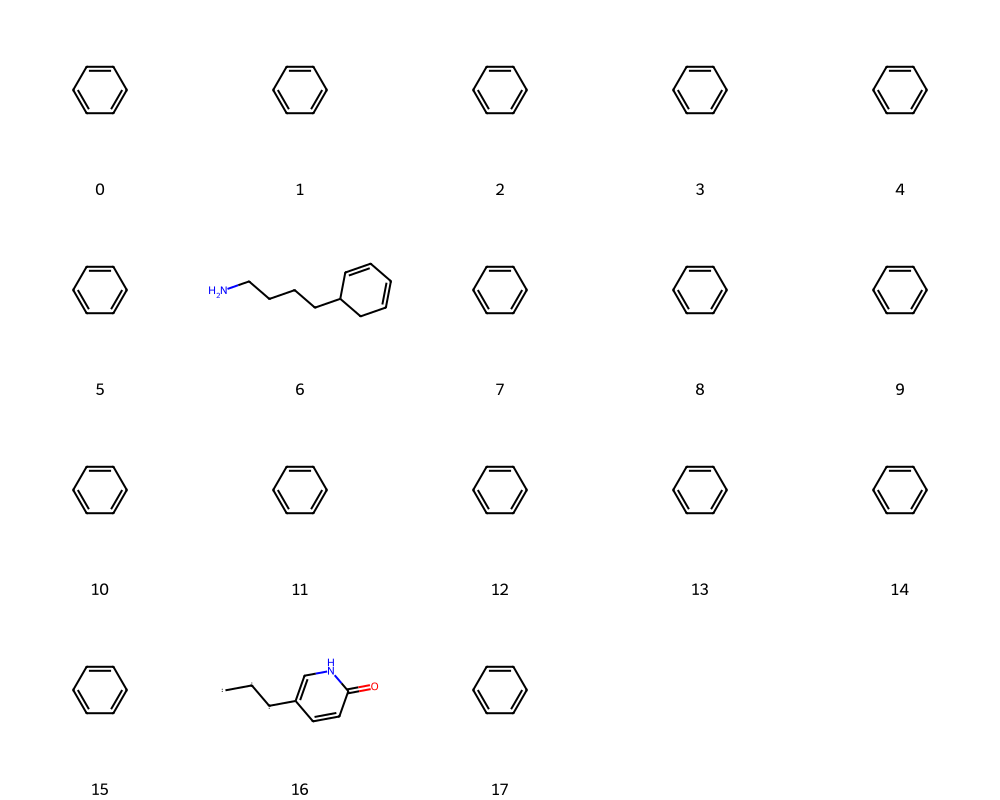

In [74]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole


mols = [Chem.MolFromSmiles(smi) for smi in new if Chem.MolFromSmiles(smi) is not None]
Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200, 200), legends=[str(i) for i in range(len(mols))])

In [62]:
model_state_path = "overfit_Only3_BPS.pkl"
torch.save(model.state_dict(), model_state_path)

print("Model saved successfully.")

Model saved successfully.


In [105]:
model_state_path = "Only3_BPS.pkl"
torch.save(model.state_dict(), model_state_path)

print("Model saved successfully.")

Model saved successfully.


# Analysis of the result

This is the initial. Gneeral one with the full pipeline.
I will do further analysis on this set. 

In [35]:
# Calculate the valid smiles

from rdkit import Chem
from rdkit.Chem import Draw
import pandas as pd

# Example dataset loading
# protease_df and nrti_df should already be loaded as shown in your initial step

# Function to check for valid RDKit Mol objects and catch potential syntax errors
def is_valid_for_drawing(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:  # Check if RDKit failed to create a Mol object
            return False
        Chem.SanitizeMol(mol)  # Attempt to sanitize the molecule, catching syntax errors
        return True
    except:  # Catch any exceptions thrown by RDKit (e.g., sanitization errors)
        return False
    
def get_valid_mols(smiles_list):
    valid_mols = []
    for smiles in smiles_list:
        if is_valid_for_drawing(smiles):
            valid_mols.append(smiles)
    return valid_mols


valid_smiles = get_valid_mols(new)
print(f"Number of valid smiles: {len(valid_smiles)}")
#as percentage
print(f"Percentage of valid smiles: {len(valid_smiles)/len(new)*100:.2f}%")

Number of valid smiles: 24
Percentage of valid smiles: 9.76%


[20:26:07] SMILES Parse Error: syntax error while parsing: (CCc1ccccn1)S(=O)(=O)c1ccc(N)cc1
[20:26:07] SMILES Parse Error: Failed parsing SMILES '(CCc1ccccn1)S(=O)(=O)c1ccc(N)cc1' for input: '(CCc1ccccn1)S(=O)(=O)c1ccc(N)cc1'
[20:26:07] SMILES Parse Error: extra close parentheses while parsing: O=C(O)c2cccc(c1ccccc1)c1ccccc1)S(=O)(=O)c1c(=O)COC(=O)N[C@H](C(=O)NCCCCC(C(N)=O)NCCCC[C@@H](CO)N(CC(C)C)S(=O)(=O)c1cccc2cccnc12)C(c1ccccc1)c1ccccc1
[20:26:07] SMILES Parse Error: Failed parsing SMILES 'O=C(O)c2cccc(c1ccccc1)c1ccccc1)S(=O)(=O)c1c(=O)COC(=O)N[C@H](C(=O)NCCCCC(C(N)=O)NCCCC[C@@H](CO)N(CC(C)C)S(=O)(=O)c1cccc2cccnc12)C(c1ccccc1)c1ccccc1' for input: 'O=C(O)c2cccc(c1ccccc1)c1ccccc1)S(=O)(=O)c1c(=O)COC(=O)N[C@H](C(=O)NCCCCC(C(N)=O)NCCCC[C@@H](CO)N(CC(C)C)S(=O)(=O)c1cccc2cccnc12)C(c1ccccc1)c1ccccc1'
[20:26:07] SMILES Parse Error: extra open parentheses for input: 'COC(=O)(=O)N[C@H](C(=O)c1ccccc1'
[20:26:07] SMILES Parse Error: extra open parentheses for input: 'CC(C)CN([C@H]CNS(=O)[C@H](C

In [36]:
protease_full = pd.read_csv('C:\\Users\\Rebe\\Documents\\Python programms\\Capstone_code\\Data\\hiv_protease_inhibitors_data_chemlb.csv')
protease = protease_full['canonical_smiles']
print(protease.shape)

nrti_full = pd.read_csv('C:\\Users\\Rebe\\Documents\\Python programms\\Capstone_code\\Data\\nrtis_hiv_chemlb_full.csv')
nrti = nrti_full['canonical_smiles']
print(nrti.shape)


(43,)
(9,)


In [37]:
#make the same one for the original dataset
#create a function for code reusability
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, Crippen
from rdkit.Chem.Draw import MolsToGridImage
import matplotlib.pyplot as plt
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, Crippen
from rdkit.Chem.Draw import MolsToGridImage
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem, RDLogger
from rdkit.Chem import BondType, AllChem, Descriptors, Descriptors3D, Draw, Lipinski, rdMolDescriptors
from rdkit.Chem.Draw import MolsToGridImage
#import DataStructs
from rdkit.Chem import AllChem, DataStructs

def get_properties(molecules):
    # Calculate properties
    properties = []
    for mol in molecules:
        mw = Descriptors.MolWt(mol)
        logp = Crippen.MolLogP(mol)
        hbd = rdMolDescriptors.CalcNumHBD(mol)
        hba = rdMolDescriptors.CalcNumHBA(mol)
        psa = rdMolDescriptors.CalcTPSA(mol)
        ro5_violations = rdMolDescriptors.CalcNumLipinskiHBA(mol) + rdMolDescriptors.CalcNumLipinskiHBD(mol)
        cx_logd = rdMolDescriptors.CalcCrippenDescriptors(mol)[1]
        mw_freebase = Descriptors.ExactMolWt(mol)
        full_mwt = Descriptors.HeavyAtomMolWt(mol)
        num_h_acceptors = rdMolDescriptors.CalcNumHBA(mol)
        num_h_donors = rdMolDescriptors.CalcNumHBD(mol)

        properties.append([mw, logp, hbd, hba, psa, ro5_violations, cx_logd, mw_freebase, full_mwt, num_h_acceptors, num_h_donors])

    # Convert to DataFrame for easier plotting
    df = pd.DataFrame(properties, columns=['MW', 'LogP', 'HBD', 'HBA', 'PSA', 'NumRo5Violations', 'CxLogD', 'MwFreebase', 'FullMwt', 'NumHAcceptors', 'NumHDonors'])

    # Plotting
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    df.hist(ax=ax, color = 'purple')
    plt.title('BPS full pipeline properties distribution')
    plt.tight_layout()
    plt.show()
    return df

C:\Users\Rebe\AppData\Local\Temp\ipykernel_14060\1062921395.py:43: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.hist(ax=ax, color = 'purple')


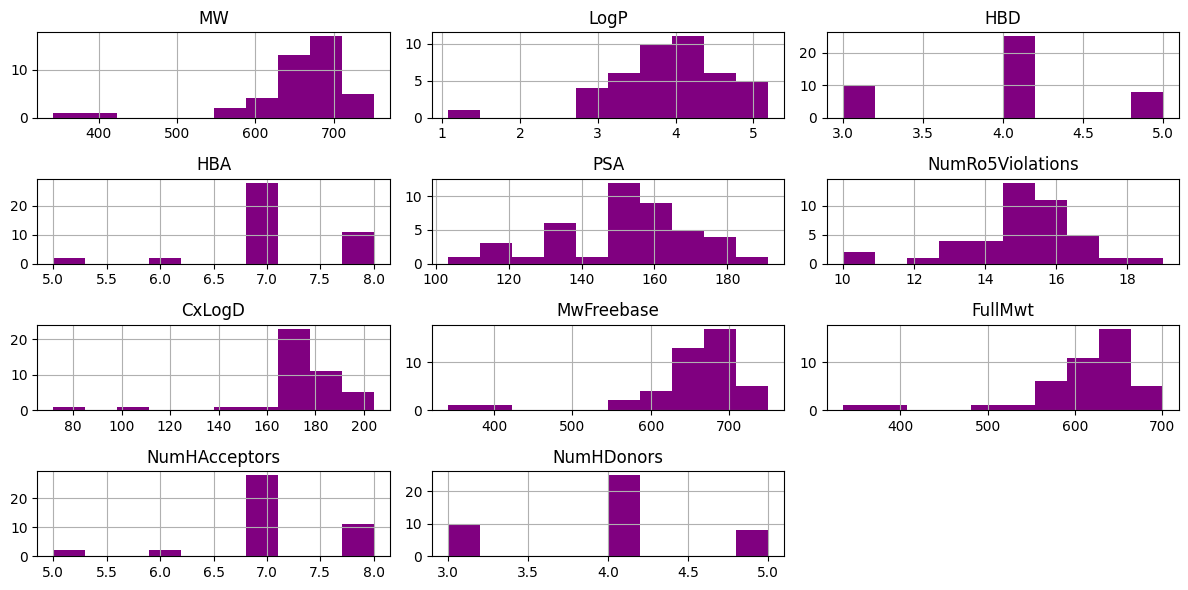

C:\Users\Rebe\AppData\Local\Temp\ipykernel_14060\1062921395.py:43: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.hist(ax=ax, color = 'purple')


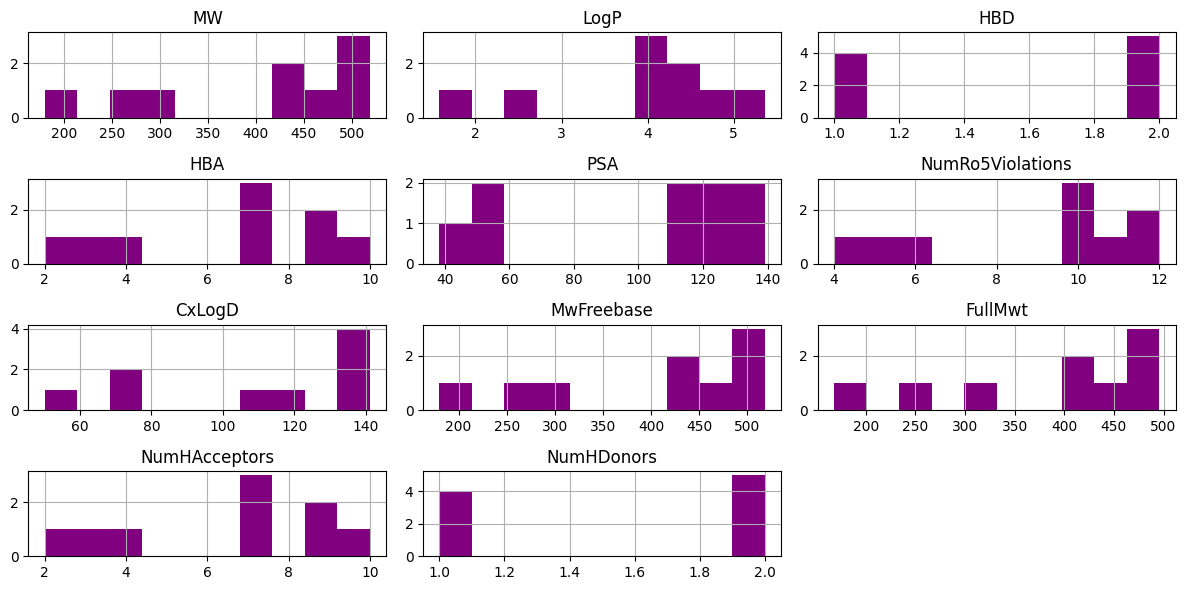

C:\Users\Rebe\AppData\Local\Temp\ipykernel_14060\1062921395.py:43: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.hist(ax=ax, color = 'purple')


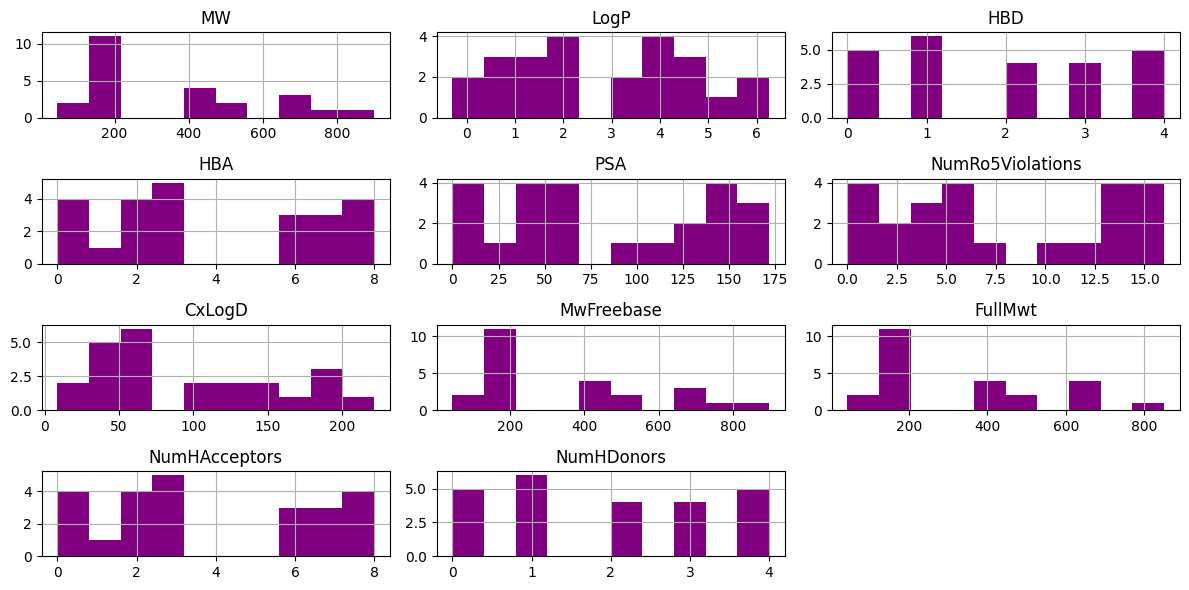

In [38]:
df_protease = get_properties([Chem.MolFromSmiles(smi) for smi in protease if Chem.MolFromSmiles(smi) is not None])
df_nrti = get_properties([Chem.MolFromSmiles(smi) for smi in nrti if Chem.MolFromSmiles(smi) is not None])
df = get_properties([Chem.MolFromSmiles(smi) for smi in valid_smiles if Chem.MolFromSmiles(smi) is not None])

In [39]:
import pandas as pd
from scipy.stats import mannwhitneyu
from numpy.random import seed

def compare_molecular_properties(descriptor, df_generated, df_protease, df_nrti):
    """
    Perform Mann-Whitney U tests to compare a molecular descriptor between generated molecules
    and both protease inhibitors and NRTIs.

    Parameters:
    - descriptor: The molecular descriptor to compare.
    - df_generated: DataFrame containing descriptors for generated molecules.
    - df_protease: DataFrame containing descriptors for protease inhibitors.
    - df_nrti: DataFrame containing descriptors for NRTIs.

    Returns:
    - A DataFrame with the test results.
    """
    # Seed the random number generator for reproducibility
    seed(3)
    
    # Extract descriptor values for each group
    generated_values = df_generated[descriptor].dropna()
    protease_values = df_protease[descriptor].dropna()
    nrti_values = df_nrti[descriptor].dropna()

    # Compare generated molecules with protease inhibitors
    stat_protease, p_protease = mannwhitneyu(generated_values, protease_values, alternative='two-sided')

    # Compare generated molecules with NRTIs
    stat_nrti, p_nrti = mannwhitneyu(generated_values, nrti_values, alternative='two-sided')

    # Interpret results
    alpha = 0.05
    interpretation_protease = 'Different distribution (reject H0)' if p_protease <= alpha else 'Same distribution (fail to reject H0)'
    interpretation_nrti = 'Different distribution (reject H0)' if p_nrti <= alpha else 'Same distribution (fail to reject H0)'

    # Compile results into a DataFrame
    results_df = pd.DataFrame({
        'Descriptor': [descriptor, descriptor],
        'Comparison': ['Generated vs. Protease', 'Generated vs. NRTI'],
        'Statistics': [stat_protease, stat_nrti],
        'P-Value': [p_protease, p_nrti],
        'Interpretation': [interpretation_protease, interpretation_nrti]
    })

    return results_df

def all_mannwhitney(df_generated, df_protease, df_nrti, descriptors):
    """
    Compare all specified descriptors between generated molecules, protease inhibitors, and NRTIs.

    Parameters:
    - df_generated: DataFrame with generated molecules' properties.
    - df_protease: DataFrame with protease inhibitors' properties.
    - df_nrti: DataFrame with NRTIs' properties.
    - descriptors: List of descriptors to compare.

    Returns:
    - A DataFrame aggregating all comparison results.
    """
    all_results = pd.DataFrame()
    for descriptor in descriptors:
        results = compare_molecular_properties(descriptor, df_generated, df_protease, df_nrti)
        all_results = pd.concat([all_results, results], ignore_index=True)
    
    return all_results

# Example usage
# Assuming df_generated, df_protease, and df_nrti are your DataFrames containing the molecular properties
descriptors = ['MW', 'LogP', 'HBD', 'HBA', 'PSA', 'NumRo5Violations', 'CxLogD', 'MwFreebase', 'FullMwt', 'NumHAcceptors', 'NumHDonors']
comparison_results = all_mannwhitney(df, df_protease, df_nrti, descriptors)

comparison_results

,Descriptor,Comparison,Statistics,P-Value,Interpretation
0,MW,Generated vs. Protease,191.0,2.197301e-05,Different distribution (reject H0)
1,MW,Generated vs. NRTI,84.0,3.420665e-01,Same distribution (fail to reject H0)
2,LogP,Generated vs. Protease,358.0,3.941200e-02,Different distribution (reject H0)
3,LogP,Generated vs. NRTI,68.0,1.102449e-01,Same distribution (fail to reject H0)
4,HBD,Generated vs. Protease,132.5,1.261230e-07,Different distribution (reject H0)
5,HBD,Generated vs. NRTI,119.0,6.622265e-01,Same distribution (fail to reject H0)
6,HBA,Generated vs. Protease,213.0,2.713960e-05,Different distribution (reject H0)
7,HBA,Generated vs. NRTI,56.0,3.554796e-02,Different distribution (reject H0)
8,PSA,Generated vs. Protease,150.5,1.752199e-06,Different distribution (reject H0)
9,PSA,Generated vs. NRTI,90.0,4.788795e-01,Same distribution (fail to reject H0)


In [40]:
#count the ones with same distribution
same_distribution = comparison_results[comparison_results['Interpretation'] == 'Same distribution (fail to reject H0)']
len(same_distribution)/len(comparison_results)*100



40.909090909090914

In [41]:
def calculate_average_tanimoto_similarity(smiles_list_1, smiles_list_2):
    """
    Calculates the average Tanimoto similarity between two lists of SMILES strings.
    
    Parameters:
    - smiles_list_1: A list of SMILES strings.
    - smiles_list_2: Another list of SMILES strings to compare against the first list.
    
    Returns:
    - The average Tanimoto similarity between all pairs of molecules from the two lists.
    """
    # Generate RDKit Mol objects
    mols_1 = [Chem.MolFromSmiles(smile) for smile in smiles_list_1 if smile is not None]
    mols_2 = [Chem.MolFromSmiles(smile) for smile in smiles_list_2 if smile is not None]
    
    # Generate fingerprints
    fps_1 = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024) for mol in mols_1]
    fps_2 = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024) for mol in mols_2]
    
    # Calculate pairwise Tanimoto similarities
    similarity_matrix = []
    for fp1 in fps_1:
        row_similarities = [DataStructs.FingerprintSimilarity(fp1, fp2) for fp2 in fps_2]
        similarity_matrix.append(row_similarities)
    
    # Convert similarity matrix to a numpy array for easier analysis
    similarity_array = np.array(similarity_matrix)
    
    # Compute the average similarity
    average_similarity = similarity_array.mean()
    
    return average_similarity

In [42]:
nrti_gen = calculate_average_tanimoto_similarity(nrti, valid_smiles)
protease_gen = calculate_average_tanimoto_similarity(protease, valid_smiles)

print(f"Average Tanimoto similarity between generated molecules and NRTIs: {nrti_gen}")
print(f"Average Tanimoto similarity between generated molecules and protease inhibitors: {protease_gen}")

Average Tanimoto similarity between generated molecules and NRTIs: 0.09467775915004666
Average Tanimoto similarity between generated molecules and protease inhibitors: 0.24659917284397193


In [43]:
generated_generated = calculate_average_tanimoto_similarity(valid_smiles, valid_smiles)
print(f"Average Tanimoto similarity between generated molecules: {generated_generated}")

Average Tanimoto similarity between generated molecules: 0.22349897654581044


In [44]:
def ro5_violations(smiles_list):
    """
    Calculates the average number of Lipinski Rule of Five violations for a list of SMILES strings.
    
    Parameters:
    - smiles_list: A list of SMILES strings.
    
    Returns:
    - The average number of Ro5 violations for the molecules in the list.
    """
    # Generate RDKit Mol objects
    mols = [Chem.MolFromSmiles(smile) for smile in smiles_list if smile is not None]
    
    # Calculate the number of violations for each molecule
    violations = [Lipinski.NumHAcceptors(mol) > 10 or Lipinski.NumHDonors(mol) > 5 or Descriptors.MolWt(mol) > 500 or Crippen.MolLogP(mol) > 5 for mol in mols]

    # Calculate the average number of violations
    average_violations = sum(violations) / len(violations)
    
    return average_violations

In [45]:
gen_lipinski = ro5_violations(valid_smiles)
print(f"Number of Lipinski rule violations: {gen_lipinski}")


Number of Lipinski rule violations: 0.3333333333333333


In [46]:
# the qed is a quantitative measure of drug-likeness
from rdkit import Chem
from rdkit.Chem import QED



def calculate_qed(smiles_list):
    """
    Calculates the quantitative estimate of drug-likeness (QED) for a list of SMILES strings.

    Parameters:
    - smiles_list: A list of SMILES strings.

    Returns:
    - The average QED for the input molecules.
    """
    # Generate RDKit Mol objects
    mols = [Chem.MolFromSmiles(smile) for smile in smiles_list if smile is not None]

    # Calculate QED values for each molecule
    qed_values = [QED.qed(mol) for mol in mols if mol is not None]

    # Compute the average QED value if there are any valid molecules; otherwise, return 0
    average_qed = sum(qed_values) / len(qed_values) if qed_values else 0

    return average_qed

In [47]:
gen_qed = calculate_qed(valid_smiles)
print(f"Average QED: {gen_qed}")

Average QED: 0.4123097142929137
